# Discussion 2 – Regression Workflows with the Ames Housing Data

## Welcome 👋

In this notebook, you will:

- Fit **linear regression** and understand **gradient descent**  
- Explore **Ridge and Lasso regression** with feature transformations  
- Perform **parameter tuning** and compare models using validation errors

We will use a **reproducible workflow**: load and clean data, split into train/test, fit multiple models, and evaluate performance.

---

## Learning Goals

By the end of this discussion, you will be able to:

1. Clean and preprocess a real-world dataset  
2. Implement **OLS regression** and **batch gradient descent**  
3. Apply **Ridge and Lasso regression** with transformations  
4. **Tune hyperparameters** and choose based on validation errors  
5. **Compare models** using validation errors

## Step 1: Load Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from collections import Counter

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

## Step 2: Data Preperation
- Load CSV data
- Set random seed for reproducibility
- Perform basic data cleaning (For demonstration purpose!! You should be more careful in this step for real-world application)

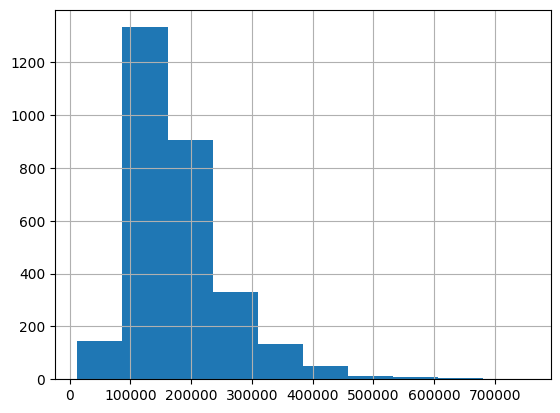

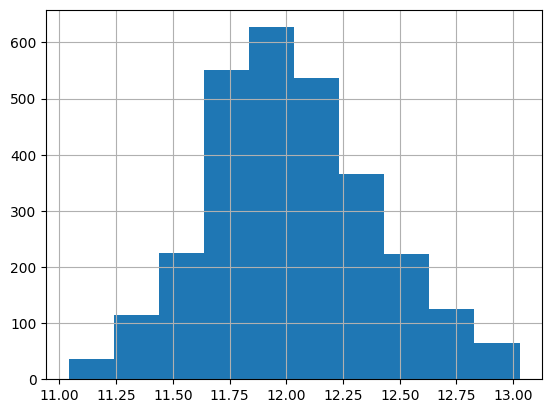

,Overall Qual,Gr Liv Area,Total Bsmt SF,Garage Area,Year Built,Full Bath,TotRms AbvGrd,SalePrice
0,6,1656,1080.0,528.0,1960,1,7,12.278393
1,5,896,882.0,730.0,1961,1,5,11.561716
2,6,1329,1329.0,312.0,1958,1,6,12.055250
3,7,2110,2110.0,522.0,1968,2,8,12.404924
4,5,1629,928.0,482.0,1997,2,6,12.154253


In [2]:
# Downloaded from: https://www.kaggle.com/datasets/prevek18/ames-housing-dataset
data = pd.read_csv("AmesHousing.csv")

# Set a random seed for reproducibility
random_seed = 42
np.random.seed(random_seed)

# Perform basic data cleaning for demonstration purpose
selected_features = [
    'Overall Qual',    # overall house quality rating
    'Gr Liv Area',     # above-ground living area
    'Total Bsmt SF',   # total basement area
    'Garage Area',     # garage size
    'Year Built',      # year house was built
    'Full Bath',       # number of full bathrooms
    'TotRms AbvGrd'    # total rooms above ground
]

data_clean = data[selected_features + ["SalePrice"]].copy()

# Handle missing values by simple imputation (median)
data_clean = data_clean.fillna(data_clean.median())

# Normalize outcome through trimming and log transformation
data_clean["SalePrice"].hist()
plt.show()

lower = data_clean.SalePrice.quantile(0.01)
upper = data_clean.SalePrice.quantile(0.99)

data_clean = data_clean[(data_clean.SalePrice >= lower) & (data_clean.SalePrice <= upper)]

data_clean["SalePrice"] = np.log(data_clean["SalePrice"])

data_clean["SalePrice"].hist()
plt.show()

data_clean.head()

## Step 3: Train-Test Split & Scaling
- Why train-test split?
- Why scaling?

### 1. Train-Test Split
- The test set acts as **unseen data** to evaluate how well our model generalizes.  
- Prevents **overfitting**, since training and evaluation are on separate data.  
- Standard workflow: train on `X_train`, tune parameters, evaluate on `X_test`.  

### 2. Feature Scaling
- Features with very different scales (e.g., `Gr Liv Area` vs `Full Bath`) can make **gradient descent slow or unstable**.  
- Standardization puts all features on a **similar scale (mean 0, std 1)**.  
- Important for **Ridge and Lasso**, which penalize coefficients directly.  
- OLS can work without scaling, but scaling is recommended for gradient-based methods.


In [3]:
X = data_clean[selected_features]
y = data_clean["SalePrice"]

# First split: train (60%) and temp (40%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=random_seed
)

# Second split: validation (20%) and test (20%) from temp
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=random_seed
)

print("Train size:", X_train.shape)
print("Validation size:", X_val.shape)
print("Test size:", X_test.shape)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Train size: (1722, 7)
Validation size: (574, 7)
Test size: (574, 7)


## Step 4: Model Fitting

### OLS

In [4]:
ols_model = LinearRegression()
ols_model.fit(X_train_scaled, y_train)

# Predictions
y_train_pred = ols_model.predict(X_train_scaled)
y_val_pred = ols_model.predict(X_val_scaled)
y_test_pred = ols_model.predict(X_test_scaled)

# Compute RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"OLS Train RMSE: {train_rmse:.4f}")
print(f"OLS Validation RMSE: {val_rmse:.4f}")
print(f"OLS Test RMSE: {test_rmse:.4f}")

OLS Train RMSE: 0.1550
OLS Validation RMSE: 0.1448
OLS Test RMSE: 0.1875


### Batch Gradient Descent

In this section, we implement **batch gradient descent** to estimate linear regression coefficients.

#### Linear Regression Model

We model the outcome as:

$$
\hat{y} = X w
$$

where:  
- $X \in \mathbb{R}^{n \times (k+1)}$ is the design matrix (including an intercept column)  
- $w \in \mathbb{R}^{k+1}$ is the vector of coefficients (including the intercept)  
- $y \in \mathbb{R}^{n}$ is the outcome vector  
- $n$ is the number of observations
- $k$ is the number of features

#### Cost Function

We measure model fit using the **mean squared error (MSE)**:

$$
J(w) = \frac{1}{2n} \sum_{i=1}^{n} (x_i^\top w - y_i)^2
$$

or equivalently in matrix form:

$$
J(w) = \frac{1}{2n} \| X w - y \|^2
$$

- The factor $1/2$ simplifies the gradient computation  
- Minimizing $J(w)$ is equivalent to ordinary least squares

#### Gradient of the Cost Function

After defining the cost function, the next step is to compute its **gradient** and use it to iteratively update the coefficients. 

The gradient of the mean squared error with respect to $w$ is:

$$
\nabla_w J(w) = \frac{1}{n} X^\top (X w - y)
$$

#### Batch Gradient Descent

The `gradient_descent` function puts everything together to **iteratively minimize the cost function** and find the best coefficients.

At each iteration, the coefficients are updated using the gradient:

$$
w^{(t+1)} = w^{(t)} - \alpha \nabla_w J(w^{(t)})
$$

- $\alpha$ = learning rate (controls step size)  
- $\nabla_w J(w^{(t)})$ = gradient of the cost at the current coefficients

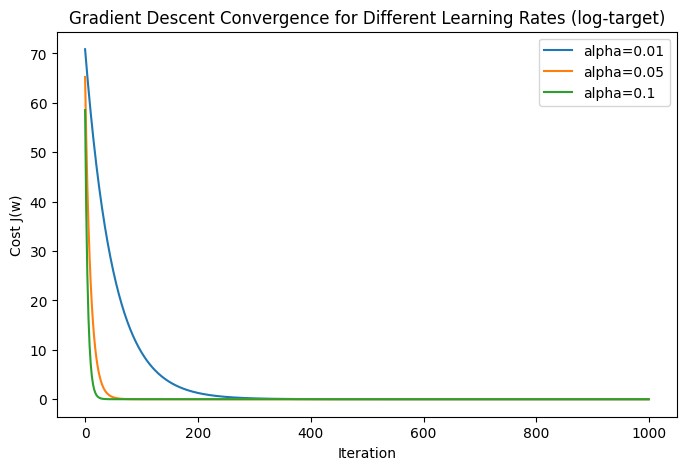

|| w_GD - w_OLS || for alpha=0.01: 0.0252369421
|| w_GD - w_OLS || for alpha=0.05: 0.0000603505
|| w_GD - w_OLS || for alpha=0.1: 0.0000000304


In [5]:
# Add intercept term to X matrices
def add_intercept(X):
    return np.c_[np.ones(X.shape[0]), X]

X_train_gd = add_intercept(X_train_scaled)
X_val_gd   = add_intercept(X_val_scaled)
X_test_gd  = add_intercept(X_test_scaled)

y_train_vec = y_train.values.reshape(-1, 1)
y_val_vec   = y_val.values.reshape(-1, 1)
y_test_vec  = y_test.values.reshape(-1, 1)

# ------------------------------
# Cost function
# ------------------------------
def compute_cost(X, y, w):
    n = X.shape[0]
    residuals = X @ w - y
    return (1/(2*n)) * np.sum(residuals**2)

# ------------------------------
# Gradient
# ------------------------------
def compute_gradient(X, y, w):
    n = X.shape[0]
    residuals = X @ w - y
    grad = (1/n) * (X.T @ residuals)
    return grad

# ------------------------------
# Batch Gradient Descent
# ------------------------------
def gradient_descent(X, y, w_init, alpha, num_iters, tol=1e-10):
    w = w_init.copy()
    cost_history = []
    
    for i in range(num_iters):
        grad = compute_gradient(X, y, w)
        w -= alpha * grad
        cost = compute_cost(X, y, w)
        cost_history.append(cost)
    return w, cost_history

# ------------------------------
# Run GD for multiple learning rates
# ------------------------------
n_features = X_train_gd.shape[1]
w_init = np.zeros((n_features, 1))
num_iters = 1000

alphas = [0.01, 0.05, 0.1]
gd_results = {}

plt.figure(figsize=(8,5))

for alpha in alphas:
    w_gd, cost_history = gradient_descent(X_train_gd, y_train_vec, w_init, alpha, num_iters)
    gd_results[alpha] = w_gd
    plt.plot(range(len(cost_history)), cost_history, label=f"alpha={alpha}")

plt.xlabel("Iteration")
plt.ylabel("Cost J(w)")
plt.title("Gradient Descent Convergence for Different Learning Rates (log-target)")
plt.legend()
plt.show()

# ------------------------------
# GD weights to OLS
# ------------------------------
w_ols = np.r_[ols_model.intercept_, ols_model.coef_].reshape(-1, 1)

for alpha, w_gd in gd_results.items():
    diff = np.linalg.norm(w_gd - w_ols)
    print(f"|| w_GD - w_OLS || for alpha={alpha}: {diff:.10f}")

### SGD, Ridge, and Lasso
Use full feature for exercises below

In [39]:
all_features = data.columns.drop(["Order", "PID", "SalePrice"]).to_list()
data_clean = data[all_features + ["SalePrice"]].copy()

# Step 1: Drop columns with >50% missing values
missing_pct = data_clean.isnull().mean()
cols_to_keep = missing_pct[missing_pct <= 0.5].index
data_clean = data_clean[cols_to_keep]

# Step 2: Initial numeric and categorical separation
numeric_features = data_clean.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = data_clean.select_dtypes(include=["object"]).columns.tolist()

# Step 3: Detect numeric-like categorical columns
numeric_like_categorical = []

for col in numeric_features:
    num_unique = data_clean[col].nunique()
    # Heuristic: if a numeric column has <15 unique values, it's likely categorical
    if num_unique <= 15:
        numeric_like_categorical.append(col)

# Remove these from numeric_features and add to categorical_features
numeric_features = [col for col in numeric_features if col not in numeric_like_categorical]
categorical_features += numeric_like_categorical

# Step 4: Impute missing values

# Numeric: median
data_clean[numeric_features] = data_clean[numeric_features].fillna(data_clean[numeric_features].median())

# Categorical: mode
for col in categorical_features:
    mode_val = data_clean[col].mode()[0]
    data_clean[col] = data_clean[col].fillna(mode_val)

# Trim & log-transform SalePrice
lower = data_clean.SalePrice.quantile(0.01)
upper = data_clean.SalePrice.quantile(0.99)
data_clean = data_clean[(data_clean.SalePrice >= lower) & (data_clean.SalePrice <= upper)]
data_clean["SalePrice"] = np.log(data_clean["SalePrice"])

X = data_clean.drop(columns = "SalePrice")
y = data_clean["SalePrice"]

# Train/Validation/Test Split (60/20/20)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=random_seed
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=random_seed
)

numeric_features = [c for c in numeric_features if c in X_train.columns]
categorical_features = [c for c in categorical_features if c in X_train.columns]

# Preprocessing: Scaling + One-Hot Encoding
preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)
])

X_train_scaled = preprocessor.fit_transform(X_train)
X_val_scaled = preprocessor.transform(X_val)
X_test_scaled = preprocessor.transform(X_test)

# Verify shapes
print("Train shape:", X_train_scaled.shape)
print("Validation shape:", X_val_scaled.shape)
print("Test shape:", X_test_scaled.shape)

Train shape: (1722, 352)
Validation shape: (574, 352)
Test shape: (574, 352)


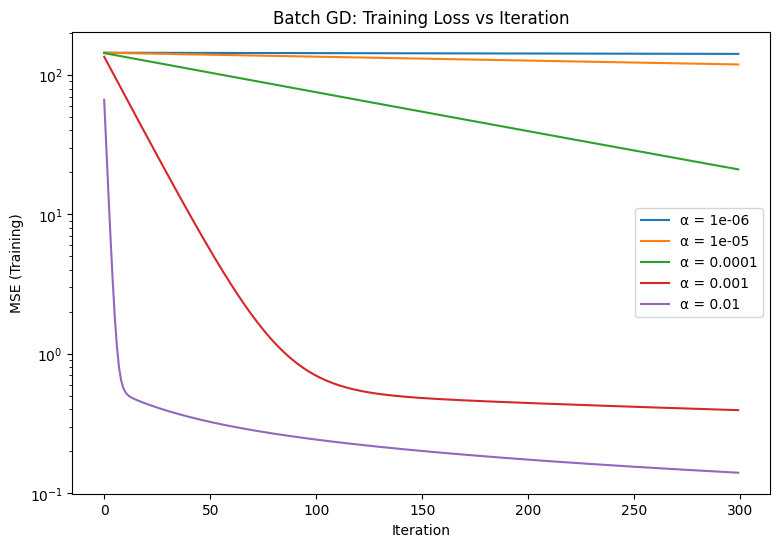

Best Batch GD α: 0.01
Train RMSE: 0.3743
Validation RMSE: 0.3678


In [42]:
X_train_gd = add_intercept(X_train_scaled)
X_val_gd   = add_intercept(X_val_scaled)

y_train_vec = y_train.values.reshape(-1, 1)
y_val_vec   = y_val.values.reshape(-1, 1)

n_features = X_train_gd.shape[1]
w_init = np.zeros((n_features, 1))

alphas_gd = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
num_iters = 300

gd_results = {}
gd_loss_curves = {}
train_rmse_gd = {}
val_rmse_gd = {}

for alpha in alphas_gd:
    w = w_init.copy()
    losses = []

    for _ in range(num_iters):
        grad = compute_gradient(X_train_gd, y_train_vec, w)
        w -= alpha * grad
        
        preds_train = X_train_gd @ w
        loss = np.mean((y_train_vec - preds_train)**2)
        losses.append(loss)

    gd_results[alpha] = w
    gd_loss_curves[alpha] = losses

    train_rmse_gd[alpha] = np.sqrt(losses[-1])
    val_preds = X_val_gd @ w
    val_rmse_gd[alpha] = np.sqrt(np.mean((y_val_vec - val_preds)**2))

plt.figure(figsize=(9,6))
for alpha, losses in gd_loss_curves.items():
    plt.plot(losses, label=f"α = {alpha}")
plt.xlabel("Iteration")
plt.ylabel("MSE (Training)")
plt.yscale("log")
plt.title("Batch GD: Training Loss vs Iteration")
plt.legend()
plt.show()

best_alpha_gd = min(val_rmse_gd, key=val_rmse_gd.get)
print(f"Best Batch GD α: {best_alpha_gd}")
print(f"Train RMSE: {train_rmse_gd[best_alpha_gd]:.4f}")
print(f"Validation RMSE: {val_rmse_gd[best_alpha_gd]:.4f}")

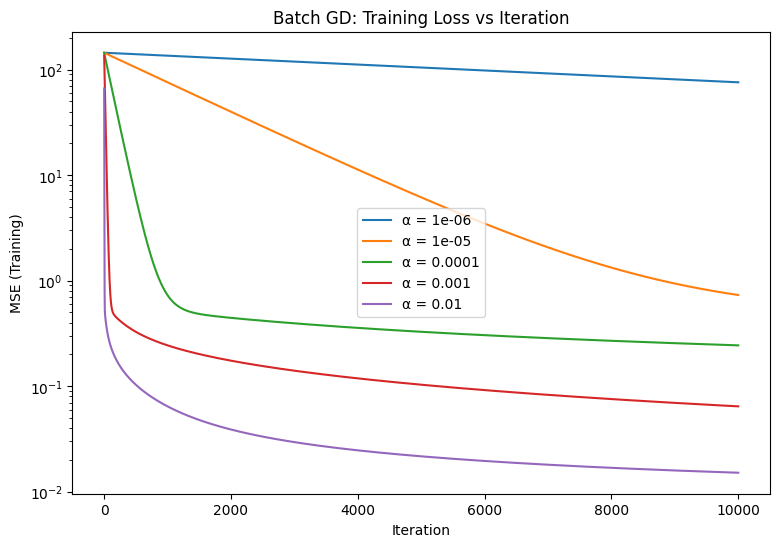

Best Batch GD α: 0.01
Train RMSE: 0.1230
Validation RMSE: 0.1446


In [45]:
X_train_gd = add_intercept(X_train_scaled)
X_val_gd   = add_intercept(X_val_scaled)

y_train_vec = y_train.values.reshape(-1, 1)
y_val_vec   = y_val.values.reshape(-1, 1)

n_features = X_train_gd.shape[1]
w_init = np.zeros((n_features, 1))

alphas_gd = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
num_iters = 10000

gd_results = {}
gd_loss_curves = {}
train_rmse_gd = {}
val_rmse_gd = {}

for alpha in alphas_gd:
    w = w_init.copy()
    losses = []

    for _ in range(num_iters):
        grad = compute_gradient(X_train_gd, y_train_vec, w)
        w -= alpha * grad
        
        preds_train = X_train_gd @ w
        loss = np.mean((y_train_vec - preds_train)**2)
        losses.append(loss)

    gd_results[alpha] = w
    gd_loss_curves[alpha] = losses

    train_rmse_gd[alpha] = np.sqrt(losses[-1])
    val_preds = X_val_gd @ w
    val_rmse_gd[alpha] = np.sqrt(np.mean((y_val_vec - val_preds)**2))

plt.figure(figsize=(9,6))
for alpha, losses in gd_loss_curves.items():
    plt.plot(losses, label=f"α = {alpha}")
plt.xlabel("Iteration")
plt.ylabel("MSE (Training)")
plt.yscale("log")
plt.title("Batch GD: Training Loss vs Iteration")
plt.legend()
plt.show()

best_alpha_gd = min(val_rmse_gd, key=val_rmse_gd.get)
print(f"Best Batch GD α: {best_alpha_gd}")
print(f"Train RMSE: {train_rmse_gd[best_alpha_gd]:.4f}")
print(f"Validation RMSE: {val_rmse_gd[best_alpha_gd]:.4f}")

### Stochastic Gradient Descent

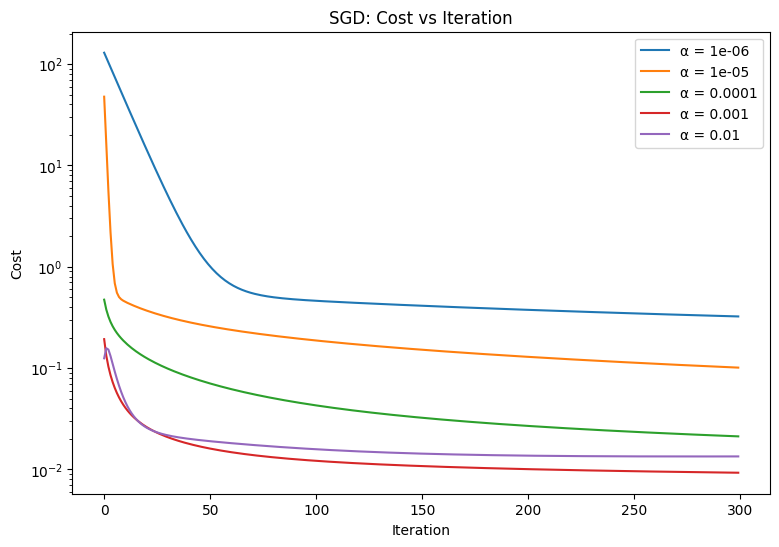

Best SGD α: 0.001
Train RMSE: 0.0963
Validation RMSE: 0.1148


In [32]:
alphas_sgd = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
train_rmse_sgd = {}
val_rmse_sgd = {}
loss_curves = {}

for alpha in alphas_sgd:
    sgd = SGDRegressor(loss="squared_error", eta0=alpha, penalty = None, learning_rate = "constant", 
                       max_iter=1, warm_start=True, random_state=random_seed)
    n_epochs = 300
    losses = []
    
    for _ in range(n_epochs):
        sgd.fit(X_train_scaled, y_train)
        preds = sgd.predict(X_train_scaled)
        loss = mean_squared_error(y_train, preds)
        losses.append(loss)
    
    loss_curves[alpha] = losses
    train_rmse_sgd[alpha] = np.sqrt(mean_squared_error(y_train, sgd.predict(X_train_scaled)))
    val_rmse_sgd[alpha] = np.sqrt(mean_squared_error(y_val, sgd.predict(X_val_scaled)))

# Plot loss curves
plt.figure(figsize=(9,6))
for alpha, losses in loss_curves.items():
    plt.plot(losses, label=f"α = {alpha}")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("SGD: Cost vs Iteration")
plt.yscale("log")
plt.legend()
plt.show()

best_alpha_sgd = min(val_rmse_sgd, key=val_rmse_sgd.get)
print(f"Best SGD α: {best_alpha_sgd}")
print(f"Train RMSE: {train_rmse_sgd[best_alpha_sgd]:.4f}")
print(f"Validation RMSE: {val_rmse_sgd[best_alpha_sgd]:.4f}")

Best Ridge λ: 0.3593813663804626
Train RMSE: 0.0872
Validation RMSE: 0.0981


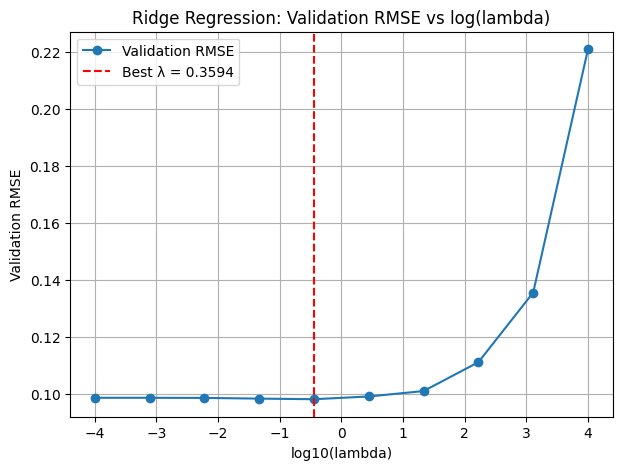

In [8]:
# Ridge Regression (Full Feature)
lambdas = np.logspace(-4, 4, 10)
val_rmses = []
best_ridge_rmse = float("inf")
best_ridge_alpha = None

for alpha in lambdas:
    ridge = Ridge(alpha=alpha, random_state=random_seed)
    ridge.fit(X_train_scaled, y_train)
    rmse_val = np.sqrt(mean_squared_error(y_val, ridge.predict(X_val_scaled)))
    val_rmses.append(rmse_val)
    
    if rmse_val < best_ridge_rmse:
        best_ridge_rmse = rmse_val
        best_ridge_alpha = alpha
        best_ridge_model = ridge

print(f"Best Ridge λ: {best_ridge_alpha}")
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, best_ridge_model.predict(X_train_scaled))):.4f}")
print(f"Validation RMSE: {best_ridge_rmse:.4f}")

# Plot Validation RMSE vs log(lambda)
plt.figure(figsize=(7,5))
plt.plot(np.log10(lambdas), val_rmses, marker='o', label='Validation RMSE')
plt.axvline(np.log10(best_ridge_alpha), color='red', linestyle='--', label=f'Best λ = {best_ridge_alpha:.4g}')
plt.xlabel('log10(lambda)')
plt.ylabel('Validation RMSE')
plt.title('Ridge Regression: Validation RMSE vs log(lambda)')
plt.legend()
plt.grid(True)
plt.show()

Best Lasso λ: 0.0001
Train RMSE: 0.0890
Validation RMSE: 0.0949


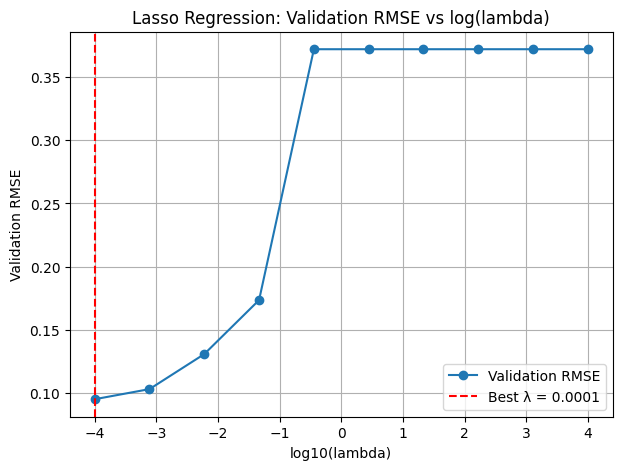

In [9]:
# Lasso Regression (Full Feature)
best_lasso_rmse = float("inf")
best_lasso_alpha = None
val_rmses_lasso = []

for alpha in lambdas:
    lasso = Lasso(alpha=alpha, random_state=random_seed)
    lasso.fit(X_train_scaled, y_train)
    rmse_val = np.sqrt(mean_squared_error(y_val, lasso.predict(X_val_scaled)))
    val_rmses_lasso.append(rmse_val)
    
    if rmse_val < best_lasso_rmse:
        best_lasso_rmse = rmse_val
        best_lasso_alpha = alpha
        best_lasso_model = lasso

print(f"Best Lasso λ: {best_lasso_alpha}")
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, best_lasso_model.predict(X_train_scaled))):.4f}")
print(f"Validation RMSE: {best_lasso_rmse:.4f}")

# Plot Validation RMSE vs log(lambda)
plt.figure(figsize=(7,5))
plt.plot(np.log10(lambdas), val_rmses_lasso, marker='o', label='Validation RMSE')
plt.axvline(np.log10(best_lasso_alpha), color='red', linestyle='--', label=f'Best λ = {best_lasso_alpha:.4g}')
plt.xlabel('log10(lambda)')
plt.ylabel('Validation RMSE')
plt.title('Lasso Regression: Validation RMSE vs log(lambda)')
plt.legend()
plt.grid(True)
plt.show()

### Polynomial Transformation 

In [10]:
poly_features = ['Gr Liv Area', 'Overall Qual']

# Initialize polynomial transformer (degree=2 includes squares and interactions)
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)

# Fit on selected features
poly_matrix = poly.fit_transform(data_clean[poly_features])

# Get new feature names
poly_feature_names = poly.get_feature_names_out(poly_features)

# Create DataFrame for new polynomial features (skip original features)
poly_df = pd.DataFrame(poly_matrix[:, len(poly_features):], 
                       columns=poly_feature_names[len(poly_features):],
                       index=data_clean.index)

# Combine with original data_clean
data_aug = pd.concat([data_clean, poly_df], axis=1)

# Check shape and first few rows
print("Original data_clean shape:", data_clean.shape)
print("Augmented data shape:", data_aug.shape)
data_aug.head()

Original data_clean shape: (2870, 75)
Augmented data shape: (2870, 78)


,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,...,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice,Gr Liv Area^2,Gr Liv Area Overall Qual,Overall Qual^2
0,20,RL,141.0,31770,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,5,2010,WD,Normal,12.278393,2742336.0,9936.0,36.0
1,20,RH,80.0,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,6,2010,WD,Normal,11.561716,802816.0,4480.0,25.0
2,20,RL,81.0,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,12500,6,2010,WD,Normal,12.055250,1766241.0,7974.0,36.0
3,20,RL,93.0,11160,Pave,Reg,Lvl,AllPub,Corner,Gtl,...,0,0,4,2010,WD,Normal,12.404924,4452100.0,14770.0,49.0
4,60,RL,74.0,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,3,2010,WD,Normal,12.154253,2653641.0,8145.0,25.0


In [11]:
# !!! SAME PROCESS AS BEFORE, JUST WITH data_aug INSTEAD OF data_clean !!!
X = data_aug.drop(columns="SalePrice")
y = data_aug["SalePrice"]

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=random_seed
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=random_seed
)

numeric_features_aug = numeric_features + poly_df.columns.tolist()
numeric_features_aug = [c for c in numeric_features_aug if c in X_train.columns]
categorical_features_aug = [c for c in categorical_features if c in X_train.columns]

preprocessor_aug = ColumnTransformer(transformers=[
    ("num", StandardScaler(), numeric_features_aug),
    ("cat", OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features_aug)
])

X_train_scaled_aug = preprocessor_aug.fit_transform(X_train)
X_val_scaled_aug = preprocessor_aug.transform(X_val)
X_test_scaled_aug = preprocessor_aug.transform(X_test)

print("Train shape (augmented):", X_train_scaled_aug.shape)
print("Validation shape (augmented):", X_val_scaled_aug.shape)
print("Test shape (augmented):", X_test_scaled_aug.shape)

Train shape (augmented): (1722, 355)
Validation shape (augmented): (574, 355)
Test shape (augmented): (574, 355)


### Ridge with Feature Transformation

Best Ridge λ (augmented): 2.782559402207126
Train RMSE: 0.0894
Validation RMSE: 0.0973


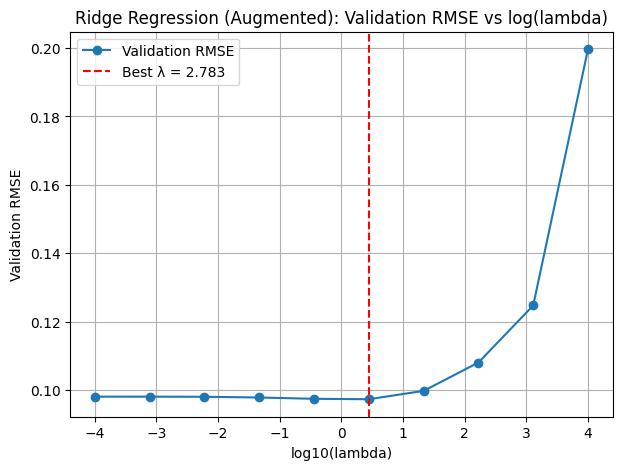

In [12]:
# Ridge Regression on Augmented Features
lambdas = np.logspace(-4, 4, 10)
val_rmses_aug = []
best_ridge_rmse_aug = float("inf")
best_ridge_alpha_aug = None

for alpha in lambdas:
    ridge = Ridge(alpha=alpha, random_state=random_seed)
    ridge.fit(X_train_scaled_aug, y_train)
    rmse_val = np.sqrt(mean_squared_error(y_val, ridge.predict(X_val_scaled_aug)))
    val_rmses_aug.append(rmse_val)
    
    if rmse_val < best_ridge_rmse_aug:
        best_ridge_rmse_aug = rmse_val
        best_ridge_alpha_aug = alpha
        best_ridge_model_aug = ridge

print(f"Best Ridge λ (augmented): {best_ridge_alpha_aug}")
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, best_ridge_model_aug.predict(X_train_scaled_aug))):.4f}")
print(f"Validation RMSE: {best_ridge_rmse_aug:.4f}")

# Plot Validation RMSE vs log(lambda)
plt.figure(figsize=(7,5))
plt.plot(np.log10(lambdas), val_rmses_aug, marker='o', label='Validation RMSE')
plt.axvline(np.log10(best_ridge_alpha_aug), color='red', linestyle='--', 
            label=f'Best λ = {best_ridge_alpha_aug:.4g}')
plt.xlabel('log10(lambda)')
plt.ylabel('Validation RMSE')
plt.title('Ridge Regression (Augmented): Validation RMSE vs log(lambda)')
plt.legend()
plt.grid(True)
plt.show()

### Lasso with Feature Transformation

Best Lasso λ (augmented): 0.0001
Train RMSE: 0.0883
Validation RMSE: 0.0952


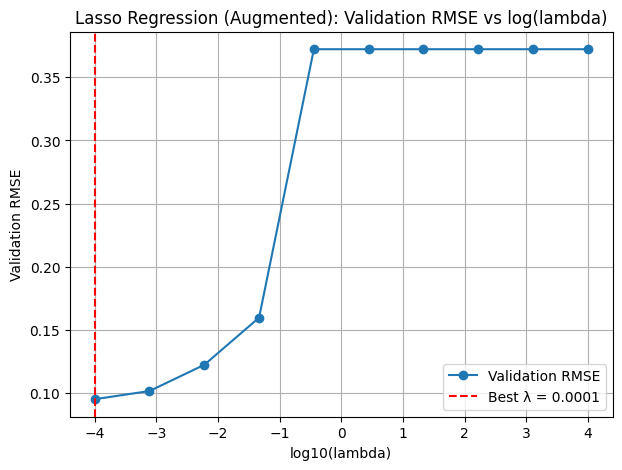

In [13]:
# Lasso Regression on Augmented Features
best_lasso_rmse_aug = float("inf")
best_lasso_alpha_aug = None
val_rmses_lasso_aug = []

for alpha in lambdas:
    lasso = Lasso(alpha=alpha, random_state=random_seed)
    lasso.fit(X_train_scaled_aug, y_train)
    rmse_val = np.sqrt(mean_squared_error(y_val, lasso.predict(X_val_scaled_aug)))
    val_rmses_lasso_aug.append(rmse_val)
    
    if rmse_val < best_lasso_rmse_aug:
        best_lasso_rmse_aug = rmse_val
        best_lasso_alpha_aug = alpha
        best_lasso_model_aug = lasso

print(f"Best Lasso λ (augmented): {best_lasso_alpha_aug}")
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, best_lasso_model_aug.predict(X_train_scaled_aug))):.4f}")
print(f"Validation RMSE: {best_lasso_rmse_aug:.4f}")

# Plot Validation RMSE vs log(lambda)
plt.figure(figsize=(7,5))
plt.plot(np.log10(lambdas), val_rmses_lasso_aug, marker='o', label='Validation RMSE')
plt.axvline(np.log10(best_lasso_alpha_aug), color='red', linestyle='--', 
            label=f'Best λ = {best_lasso_alpha_aug:.4g}')
plt.xlabel('log10(lambda)')
plt.ylabel('Validation RMSE')
plt.title('Lasso Regression (Augmented): Validation RMSE vs log(lambda)')
plt.legend()
plt.grid(True)
plt.show()

### Summary Table

In [14]:
rmse_summary = pd.DataFrame({
    "Model": [
        "SGD Linear Regression", 
        "Ridge (Full Features)", 
        "Lasso (Full Features)", 
        "Ridge (Augmented Features)", 
        "Lasso (Augmented Features)"
    ],
    "Validation RMSE": [
        val_rmse_sgd[best_alpha_sgd], 
        best_ridge_rmse,
        best_lasso_rmse, 
        best_ridge_rmse_aug, 
        best_lasso_rmse_aug
    ]
})

# Sort by validation RMSE
rmse_summary = rmse_summary.sort_values(by="Validation RMSE").reset_index(drop=True)
rmse_summary

,Model,Validation RMSE
0,Lasso (Full Features),0.094868
1,Lasso (Augmented Features),0.095167
2,Ridge (Augmented Features),0.097341
3,Ridge (Full Features),0.098108
4,SGD Linear Regression,0.111816


In [15]:
best_model_name = rmse_summary.loc[0, "Model"]
print(f"Best model based on validation RMSE: {best_model_name}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, best_lasso_model.predict(X_test_scaled))):.4f}")

Best model based on validation RMSE: Lasso (Full Features)
Test RMSE: 0.1606
